In [ ]:
!pip install unidecode
!python -m spacy download en_core_web_md
!wget https://raw.githubusercontent.com/zhangruiskyline/NLP_DeepLearning/master/all_book_titles.txt -P data

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import string, re, unidecode
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import TruncatedSVD, PCA
from scipy.spatial.distance import cosine
import nltk, spacy
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from gensim.models import Word2Vec

nlp = spacy.load('en_core_web_md')
nltk.download(['stopwords', 'wordnet', 'vader_lexicon', 'omw-1.4'])

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

# 1) Spacey Pretrained Word Vector

Word vectors - also called word embeddings - are mathematical descriptions of individual words such that words that appear frequently together in the language will have similar values. In this way we can mathematically derive context. The word vector for "lion" will be closer in value to "cat" than to "dandelion". <br>

Since spaCy employs 300 dimensions, word vectors are stored as 300-item arrays using [word2vec](https://en.wikipedia.org/wiki/Word2vec) as family of algorithms.

In [ ]:
print(nlp(u'lion').vector.shape)
print(nlp(u'The quick brown fox jumped over the lazy dogs.').vector.shape)

(300,)
(300,)


In [ ]:
# compare similarities
tokens = nlp(u'lion cat dandelion pet')
{(x, y) : x.similarity(y) for x in tokens for y in tokens}

{(lion, lion): 1.0,
 (lion, cat): 0.5265438,
 (lion, dandelion): 0.18064451,
 (lion, pet): 0.39923766,
 (cat, lion): 0.5265438,
 (cat, cat): 1.0,
 (cat, dandelion): 0.22651166,
 (cat, pet): 0.7505457,
 (dandelion, lion): 0.18064451,
 (dandelion, cat): 0.22651166,
 (dandelion, dandelion): 1.0,
 (dandelion, pet): 0.21023153,
 (pet, lion): 0.39923766,
 (pet, cat): 0.7505457,
 (pet, dandelion): 0.21023153,
 (pet, pet): 1.0}

In [ ]:
# opposite meaning, but often appear in the same context may have similar vectors.
tokens = nlp(u'like love hate')
{(x, y) : x.similarity(y) for x in tokens for y in tokens}

{(like, like): 1.0,
 (like, love): 0.657904,
 (like, hate): 0.6574652,
 (love, like): 0.657904,
 (love, love): 1.0,
 (love, hate): 0.6393099,
 (hate, like): 0.6574652,
 (hate, love): 0.6393099,
 (hate, hate): 1.0}

In [ ]:
# total of 20000 vocab
nlp.vocab.vectors.shape

(20000, 300)

In [ ]:
# out of vocab is True if the word not in the corpus
tokens = nlp(u'cat nargle john cheekean')
for token in tokens:
    print(f'{token.text:{8}}',
          f'{token.has_vector:{2}}',
          f'{token.vector_norm:{10}}',
          token.is_oov)

cat       1 6.680818557739258 False
nargle    0        0.0 True
john      1 6.533577919006348 False
cheekean  0        0.0 True


In [ ]:
# Vector arithmetic
new_vector = nlp.vocab['king'].vector - nlp.vocab['man'].vector + nlp.vocab['woman'].vector
sim = 1- cosine(new_vector, nlp.vocab['queen'].vector)
sim

0.7880843877792358

In [ ]:
# find other words that is close to the meaning
computed_similarities = []
for word in nlp.vocab:
    # Ignore words without vectors and mixed-case words:
    if word.has_vector & word.is_lower & word.is_alpha:
        similarity = 1- cosine(new_vector, word.vector)
        computed_similarities.append((word, similarity))
# sorted by decending orders
computed_similarities = sorted(computed_similarities, key=lambda item: -item[1])

In [ ]:
print([w[0].text for w in computed_similarities[:10]])

['king', 'queen', 'commoner', 'highness', 'prince', 'sultan', 'maharajas', 'princes', 'kumbia', 'kings']


# 2) Word to Vector Embedding (SVD)

Similar words tend to occur together and will have a similar context for example — Apple is a fruit. Mango is a fruit.

[Co-Occurrence Matrix with a fixed context window](https://medium.com/analytics-vidhya/co-occurrence-matrix-singular-value-decomposition-svd-31b3d3deb305)


## 2.1 Manual Training

In [ ]:
wordnet_lemmatizer = WordNetLemmatizer()
stop_words = stopwords.words('english')
def preprocess_text(text, token=True):
    text = re.sub('[^a-zA-Z]', ' ', text)
    text = unidecode.unidecode(text)
    text = [t.lower() for t in text.split() if len(t) > 2]
    text = [t for t in text if t not in stop_words]
    # text = [t.lemma_ for t in nlp(' '.join(text))]
    text = [wordnet_lemmatizer.lemmatize(t) for t in text]
    # Join the characters again to form the string.
    if token == False:
        text = ' '.join(text)
    return text

In [ ]:
sentences = [line.rstrip() for line in open('data/all_book_titles.txt')]
sentences = [preprocess_text(w, False) for w in sentences]

In [ ]:
cv = CountVectorizer()
vector = cv.fit_transform(sentences)

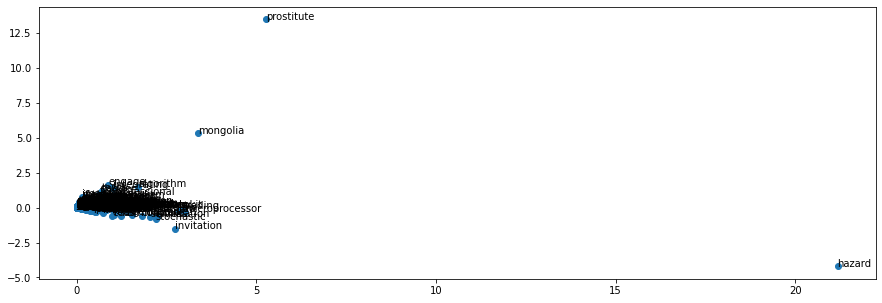

In [ ]:
word_index_map = cv.vocabulary_
D = len(word_index_map)

plt.figure(figsize=(15, 5))
svd = TruncatedSVD()
Z = svd.fit_transform(vector.toarray().T)

plt.scatter(Z[:,0], Z[:,1])
for i, w in enumerate(word_index_map):
    plt.annotate(s = [x for x in word_index_map.keys()][i], xy = (Z[i, 0], Z[i, 1]))
plt.show()

In [ ]:
df1 = pd.DataFrame()
df1['word'] = cv.vocabulary_.keys()
df1 = pd.concat([df1, pd.DataFrame(vector.toarray().T, columns=[x for x in range(vector.shape[0])])], axis=1)
df1

,word,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,...,2333,2334,2335,2336,2337,2338,2339,2340,2341,2342,2343,2344,2345,2346,2347,2348,2349,2350,2351,2352,2353,2354,2355,2356,2357,2358,2359,2360,2361,2362,2363,2364,2365,2366,2367,2368,2369,2370,2371,2372
0,philosophy,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,sex,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,love,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,reader,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,reading,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2105,nontechnical,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2106,contingency,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2107,chester,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2108,wallace,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
